# Cluster
clustering on the new climatology

In [2]:
# print name of the current environment
import os
print(os.environ.get('CONDA_DEFAULT_ENV'))

geo


In [96]:

# import libraries for working with .nc
import xarray as xr
import os   
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import dask 
import random
import glob

import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata
from pyproj import Proj, Transformer
import geopandas
from shapely.geometry import Point
import pyinterp
import pyreadr

import pygeoda
from libpysal.weights import Queen, KNN
from sklearn.cluster import AgglomerativeClustering
from gap_statistic import OptimalK


define path

In [4]:
# origin path
path = '/mnt/d/Dropbox/R_projects/SVpheno/data/CDS/daily_smoothed'


In [5]:
# load the data
ds = xr.open_mfdataset(path + '/daily_smoothed_climatology.nc')
ds

<xarray.Dataset>
Dimensions:      (dayofyear: 246, y: 388, x: 456)
Coordinates:
  * x            (x) float64 -1.764e+05 -1.724e+05 ... 1.64e+06 1.644e+06
  * y            (y) float64 9.538e+06 9.534e+06 9.53e+06 ... 7.994e+06 7.99e+06
    spatial_ref  int64 ...
  * dayofyear    (dayofyear) int64 60 61 62 63 64 65 ... 300 301 302 303 304 305
Data variables:
    chlor_a      (dayofyear, y, x) float32 dask.array<chunksize=(246, 388, 456), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20220517T132630Z
    creator_email:                  help@esa-oceancolour-cci.org
    ...                             ...
    time_coverage_start:            199803010000Z
    title:                          Copernicus Climate Change Service Ocean C...
    tracking_id:                    b96aba32-fe16-4850-b3f1-84a72901a6de
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...
    id:                             ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km...
    summary:                        Data products generated for C3S using the...

Now I need to remove the variables (doy) and latitudes that contains too many NaNs


In [6]:
ds['time'] = pd.to_datetime(ds['dayofyear'], format='%j', errors='coerce')

ds_int = ds.interpolate_na(dim='time', method='linear', limit=None)
ds_int_computed = ds_int.compute()


In [7]:
print(ds_int_computed.isnull().sum())


<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables:
    chlor_a      int64 24786977


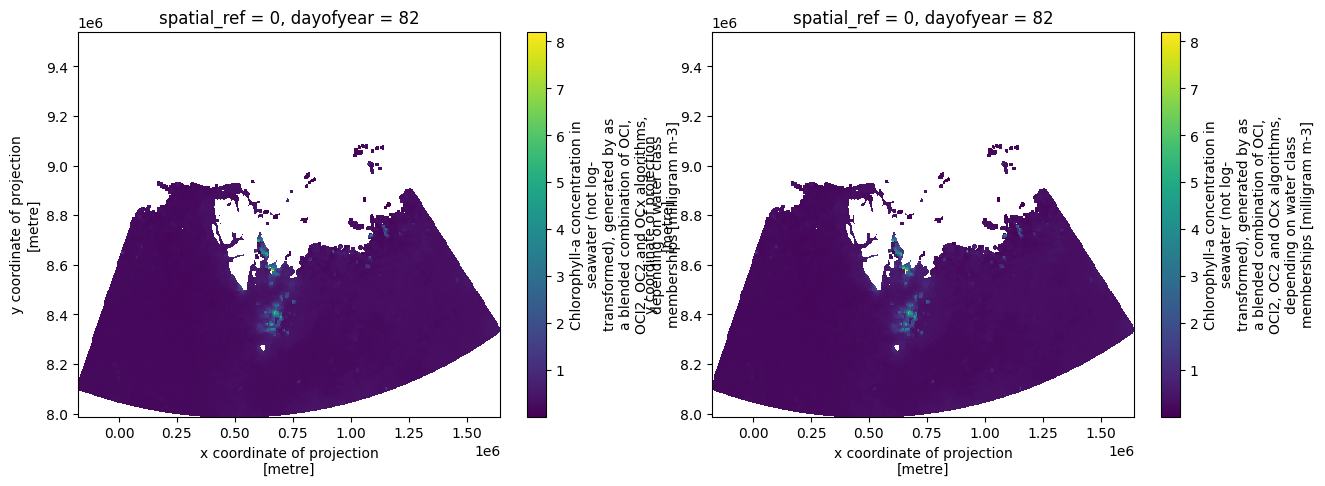

In [8]:
# plot of ds e ds_int day 150 on the same plot
day = 82
fig, ax = plt.subplots(1,2, figsize = (15,5))
ds.sel(dayofyear=day).chlor_a.plot(label='original', ax = ax[0])
ds_int_computed.sel(dayofyear=day).chlor_a.plot(label='interpolated', ax = ax[1])


non funziona!

In [9]:
nan_counts = ds['chlor_a'].isnull().sum(dim=['x', 'y'])

nan_counts_df = nan_counts.to_dataframe(name='NaN_count')


In [10]:
nan_counts_df

,spatial_ref,NaN_count
dayofyear,,
60,0,175311
61,0,171249
62,0,167679
63,0,162666
64,0,156038
...,...,...
301,0,176928
302,0,176928
303,0,176928


In [11]:
# add a column with the day of the year
nan_counts_df['dayofyear'] = nan_counts_df.index
# remove as index
nan_counts_df.reset_index(drop=True, inplace=True)


In [12]:
nan_counts_df

,spatial_ref,NaN_count,dayofyear
0,0,175311,60
1,0,171249,61
2,0,167679,62
3,0,162666,63
4,0,156038,64
...,...,...,...
241,0,176928,301
242,0,176928,302
243,0,176928,303
244,0,176928,304


In [13]:
# group for the variable dayofyear after dropping spatial_ref
result = nan_counts_df.groupby('dayofyear')['NaN_count'].sum().reset_index()
# add a column with the relative frequency
result['freq'] = result['NaN_count']/max(result['NaN_count'])*100

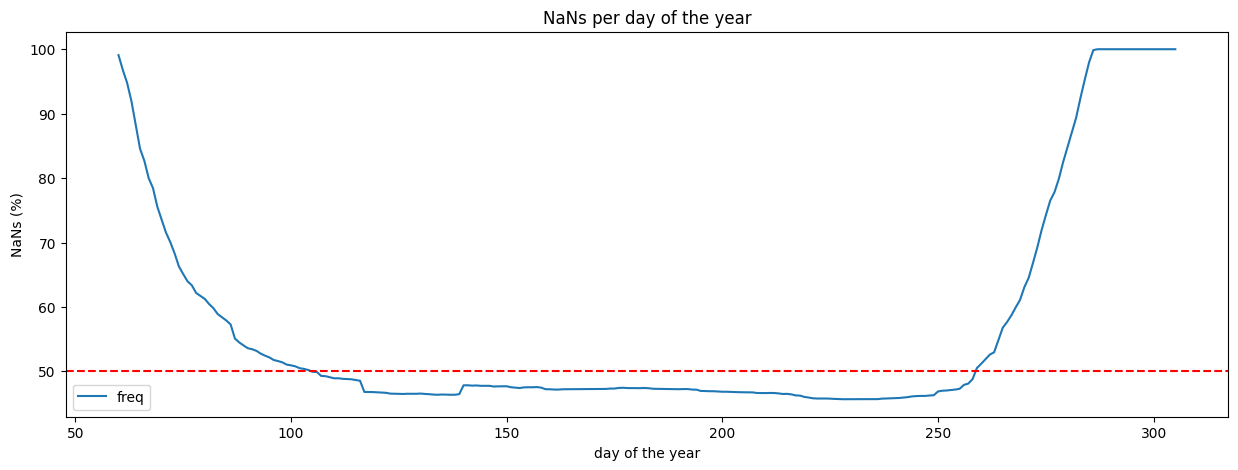

In [14]:
# plot the number of NaNs per day of the year with y as a percentage
fig, ax = plt.subplots(figsize = (15,5))
result.plot(x='dayofyear', y='freq', ax=ax)
ax.set_ylabel('NaNs (%)')
ax.set_xlabel('day of the year')
ax.set_title('NaNs per day of the year')
# horizontal line at 70%
ax.axhline(y=50, color='r', linestyle='--')
plt.show()


In [15]:
# find the days of the year with less than 70% of NaNs
valid_days = result[result['freq'] < 50]

In [16]:
valid_days

,dayofyear,NaN_count,freq
45,105,88356,49.938958
46,106,88284,49.898264
47,107,87204,49.287846
48,108,87147,49.255629
49,109,86860,49.093417
...,...,...,...
194,254,83471,47.177948
195,255,83677,47.294380
196,256,84752,47.901971
197,257,85108,48.103183


In [17]:
init = 105
end = 258


In [18]:
# select ds_int_computed with the valid days
ds_valid = ds_int_computed.sel(dayofyear=slice(init, end))

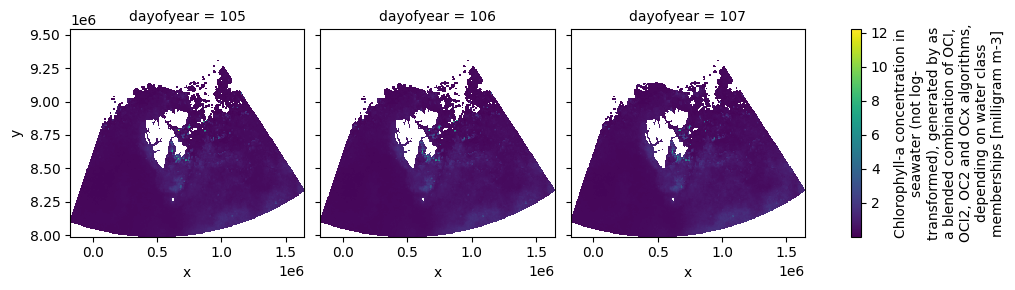

In [19]:
# plot the first 3 days
ds_valid.chlor_a.isel(dayofyear=slice(0, 3)).plot(col='dayofyear', col_wrap=3)

In [20]:
ds_valid

<xarray.Dataset>
Dimensions:      (x: 456, y: 388, dayofyear: 154, time: 246)
Coordinates:
  * x            (x) float64 -1.764e+05 -1.724e+05 ... 1.64e+06 1.644e+06
  * y            (y) float64 9.538e+06 9.534e+06 9.53e+06 ... 7.994e+06 7.99e+06
    spatial_ref  int64 0
  * dayofyear    (dayofyear) int64 105 106 107 108 109 ... 254 255 256 257 258
  * time         (time) datetime64[ns] 1900-03-01 1900-03-02 ... 1900-11-01
Data variables:
    chlor_a      (dayofyear, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20220517T132630Z
    creator_email:                  help@esa-oceancolour-cci.org
    ...                             ...
    time_coverage_start:            199803010000Z
    title:                          Copernicus Climate Change Service Ocean C...
    tracking_id:                    b96aba32-fe16-4850-b3f1-84a72901a6de
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...
    id:                             ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km...
    summary:                        Data products generated for C3S using the...

In [21]:
ds_int = ds_valid.interpolate_na(dim='dayofyear', method='linear', limit=None)
ds_int_computed = ds_int.compute()


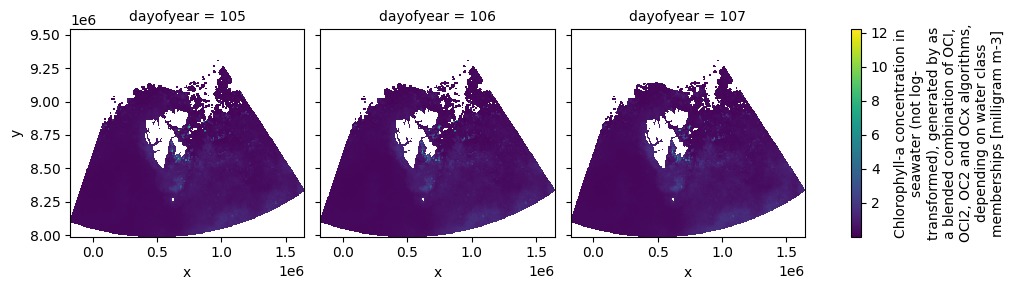

In [22]:
ds_int.chlor_a.isel(dayofyear=slice(0, 3)).plot(col='dayofyear', col_wrap=3)

In [23]:
from scipy.interpolate import interp1d

# Supponiamo che ds_valid sia il tuo dataset xarray
# ds_valid = xr.open_dataset("path_to_your_dataset.nc")

# Estrai la variabile di interesse, ad esempio, 'chlor_a'
chlor_a = ds_valid['chlor_a']

# Prepariamo un DataArray per ospitare i risultati interpolati
chlor_a_interpolated = xr.full_like(chlor_a, np.nan)

# Ciclo su tutte le combinazioni di x e y
for xi in ds_valid.x:
    for yi in ds_valid.y:
        # Estrai la serie temporale per la specifica coppia (x, y)
        ts = chlor_a.sel(x=xi, y=yi)
        
        # Ignora i punti in cui tutti i valori sono NaN
        if ts.isnull().all():
            continue

        # Prepara i dati per l'interpolazione
        valid_times = ts['dayofyear'][~ts.isnull()]
        valid_values = ts[~ts.isnull()]

        # Crea l'interpolatore
        f = interp1d(valid_times, valid_values, kind='linear', bounds_error=False)

        # Interpola lungo l'asse temporale
        interpolated_values = f(ds_valid['dayofyear'])

        # Inserisci i valori interpolati nel risultato
        chlor_a_interpolated.loc[dict(x=xi, y=yi)] = interpolated_values

# Aggiorna il dataset con la variabile interpolata
ds_valid['chlor_a_interpolated'] = chlor_a_interpolated

In [24]:
ds_valid

<xarray.Dataset>
Dimensions:               (x: 456, y: 388, dayofyear: 154, time: 246)
Coordinates:
  * x                     (x) float64 -1.764e+05 -1.724e+05 ... 1.644e+06
  * y                     (y) float64 9.538e+06 9.534e+06 ... 7.994e+06 7.99e+06
    spatial_ref           int64 0
  * dayofyear             (dayofyear) int64 105 106 107 108 ... 255 256 257 258
  * time                  (time) datetime64[ns] 1900-03-01 ... 1900-11-01
Data variables:
    chlor_a               (dayofyear, y, x) float32 nan nan nan ... nan nan nan
    chlor_a_interpolated  (dayofyear, y, x) float32 nan nan nan ... nan nan nan
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20220517T132630Z
    creator_email:                  help@esa-oceancolour-cci.org
    ...                             ...
    time_coverage_start:            199803010000Z
    title:                          Copernicus Climate Change Service Ocean C...
    tracking_id:                    b96aba32-fe16-4850-b3f1-84a72901a6de
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...
    id:                             ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km...
    summary:                        Data products generated for C3S using the...

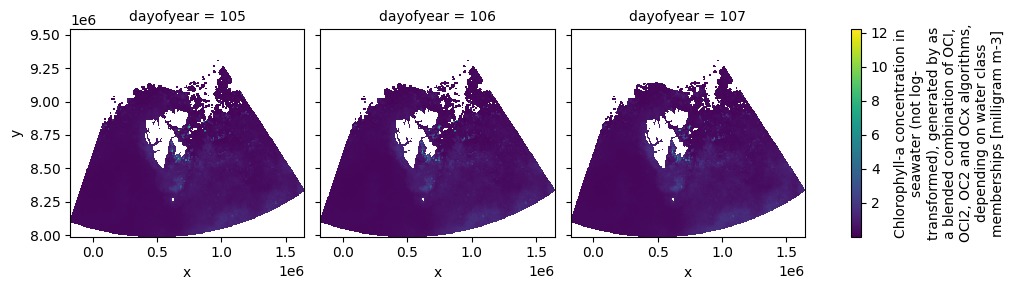

In [25]:
ds_valid.chlor_a_interpolated.isel(dayofyear=slice(0, 3)).plot(col='dayofyear', col_wrap=3)

the interpolation doesn't work as expected.
I tranform in a dataframe and then I interpolate with **pandas**


In [26]:
#transform ds_valid to a pandas dataframe
# dsdf = ds_valid.to_dataframe()


In [27]:
# save ds_valid
ds_valid.to_netcdf(path + '/daily_smoothed_climatology_valid.nc')

In [28]:
path + '/daily_smoothed_climatology_valid.nc'

'/mnt/d/Dropbox/R_projects/SVpheno/data/CDS/daily_smoothed/daily_smoothed_climatology_valid.nc'

the above bit doent work. I do it in R and import the data back in the next chunks.

see note **1.0.1_netcdf&data_frames.qmd**


then I reload the data here as pandas

In [42]:
filepath = '/mnt/d/Dropbox/R_projects/SVpheno/data/' + '1.0.1_df_valid_long.rds'
result = pyreadr.read_r(filepath) # also works for RData


In [59]:
df = result[None] # extract the pandas data frame 
df

,x,y,CHL,doy,studyarea,geoID,naprop,CHL_interpolated
0,915580.471579,9.330306e+06,NaN,105.0,1.0,23986,0.701299,0.505683
1,915580.471579,9.330306e+06,NaN,106.0,1.0,23986,0.701299,0.505683
2,915580.471579,9.330306e+06,NaN,107.0,1.0,23986,0.701299,0.505683
3,915580.471579,9.330306e+06,NaN,108.0,1.0,23986,0.701299,0.505683
4,915580.471579,9.330306e+06,NaN,109.0,1.0,23986,0.701299,0.505683
...,...,...,...,...,...,...,...,...
14714079,647580.471579,7.990306e+06,1.063588,254.0,NaN,176679,0.000000,1.063588
14714080,647580.471579,7.990306e+06,1.068690,255.0,NaN,176679,0.000000,1.068690
14714081,647580.471579,7.990306e+06,1.091180,256.0,NaN,176679,0.000000,1.091180
14714082,647580.471579,7.990306e+06,1.090710,257.0,NaN,176679,0.000000,1.090710


In [60]:
# filtre df with naprop < 0.1
df = df[df['naprop'] < 0.1]

# filtre df with studyarea < 1
df = df[df['studyarea'] == 1]
df

,x,y,CHL,doy,studyarea,geoID,naprop,CHL_interpolated
79772,1.007580e+06,9.262306e+06,0.176335,105.0,1.0,31761,0.045455,0.176335
79773,1.007580e+06,9.262306e+06,0.176335,106.0,1.0,31761,0.045455,0.176335
79774,1.007580e+06,9.262306e+06,0.176335,107.0,1.0,31761,0.045455,0.176335
79775,1.007580e+06,9.262306e+06,0.176335,108.0,1.0,31761,0.045455,0.176335
79776,1.007580e+06,9.262306e+06,0.176335,109.0,1.0,31761,0.045455,0.176335
...,...,...,...,...,...,...,...,...
14711153,5.715805e+05,7.990306e+06,1.094190,254.0,1.0,176660,0.000000,1.094190
14711154,5.715805e+05,7.990306e+06,1.066642,255.0,1.0,176660,0.000000,1.066642
14711155,5.715805e+05,7.990306e+06,1.063267,256.0,1.0,176660,0.000000,1.063267
14711156,5.715805e+05,7.990306e+06,1.060940,257.0,1.0,176660,0.000000,1.060940


In [61]:
df.shape


(13756666, 8)

# CLustering

test of the algorithm

In [63]:
df_cl_xy = df[['x','y']].drop_duplicates()
coords = np.array(df_cl_xy[['x','y']].drop_duplicates())

# df_pivotCL as geoDataFrame with x e y from coords
gdf = geopandas.GeoDataFrame(df_cl_xy, geometry=geopandas.points_from_xy(coords[:,0], coords[:,1]))
w = Queen.from_dataframe(gdf)


In [66]:
df

,x,y,CHL,doy,studyarea,geoID,naprop,CHL_interpolated
79772,1.007580e+06,9.262306e+06,0.176335,105.0,1.0,31761,0.045455,0.176335
79773,1.007580e+06,9.262306e+06,0.176335,106.0,1.0,31761,0.045455,0.176335
79774,1.007580e+06,9.262306e+06,0.176335,107.0,1.0,31761,0.045455,0.176335
79775,1.007580e+06,9.262306e+06,0.176335,108.0,1.0,31761,0.045455,0.176335
79776,1.007580e+06,9.262306e+06,0.176335,109.0,1.0,31761,0.045455,0.176335
...,...,...,...,...,...,...,...,...
14711153,5.715805e+05,7.990306e+06,1.094190,254.0,1.0,176660,0.000000,1.094190
14711154,5.715805e+05,7.990306e+06,1.066642,255.0,1.0,176660,0.000000,1.066642
14711155,5.715805e+05,7.990306e+06,1.063267,256.0,1.0,176660,0.000000,1.063267
14711156,5.715805e+05,7.990306e+06,1.060940,257.0,1.0,176660,0.000000,1.060940


In [67]:
#data
df_pivot = df.pivot(index='geoID', columns='doy', values='CHL_interpolated')


In [68]:
df_pivot

doy,105.0,106.0,107.0,108.0,109.0,110.0,111.0,112.0,113.0,114.0,...,249.0,250.0,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0
geoID,,,,,,,,,,,,,,,,,,,,,
31761,0.176335,0.176335,0.176335,0.176335,0.176335,0.176335,0.176335,0.176335,0.176335,0.176335,...,0.303142,0.301382,0.305297,0.338096,0.263099,0.255507,0.232729,0.310618,0.310618,0.310618
31762,0.173557,0.173557,0.173557,0.173557,0.173557,0.173557,0.173557,0.173557,0.173557,0.173557,...,0.331572,0.335393,0.333010,0.371637,0.345833,0.332932,0.294226,0.416330,0.315443,0.315443
32216,0.168819,0.168819,0.168819,0.168819,0.168819,0.168819,0.168819,0.168819,0.168819,0.168819,...,0.318701,0.320991,0.327326,0.381499,0.322375,0.318217,0.284609,0.309558,0.309558,0.309558
32217,0.174456,0.174456,0.174456,0.174456,0.174456,0.174456,0.174456,0.174456,0.174456,0.174456,...,0.318758,0.322774,0.329068,0.373950,0.295214,0.285854,0.238783,0.322726,0.322726,0.322726
32218,0.172829,0.172829,0.172829,0.172829,0.172829,0.172829,0.172829,0.172829,0.172829,0.167683,...,0.357122,0.368663,0.376049,0.429712,0.367970,0.350342,0.297458,0.421178,0.325139,0.325139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176656,0.407349,0.428940,0.449483,0.480402,0.517424,0.546660,0.578034,0.596711,0.637014,0.666157,...,1.209690,1.192293,1.172856,1.168227,1.149476,1.128129,1.107831,1.096630,1.081562,1.071018
176657,0.393581,0.411983,0.430047,0.456141,0.486424,0.508559,0.534912,0.554365,0.580588,0.603257,...,1.213511,1.190974,1.166481,1.153374,1.127782,1.101916,1.072815,1.056976,1.036152,1.023041
176658,0.363026,0.368670,0.390861,0.420025,0.446140,0.465574,0.491275,0.510778,0.542450,0.568252,...,1.180613,1.170270,1.149053,1.138095,1.118499,1.093920,1.060280,1.048536,1.034780,1.027769


In [72]:
# Set the seed for reproducibility
np.random.seed(123456)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=12
)
# Fit algorithm to the data
# Usa solo le colonne numeriche per il clustering (escludi oggetti Point o altre colonne non numeriche)
numeric_columns = df_pivot.select_dtypes(include=[np.number]).columns
df_numeric = df_pivot[numeric_columns]

# Ora applica il modello di clustering
model.fit(df_numeric)

AgglomerativeClustering(connectivity=<89329x89329 sparse matrix of type '<class 'numpy.float64'>'
	with 711060 stored elements in Compressed Sparse Row format>,
                        n_clusters=12)

In [75]:
from matplotlib.colors import ListedColormap


# attacco la colonna cluster al df_cl
df_cluster = pd.DataFrame({'x':df_cl_xy.x, 'y':df_cl_xy.y, 'cluster':model.labels_})
df_cluster.head()

df_xr = df_cluster.set_index(['y','x']).to_xarray()


num_clusters = np.unique(df_cluster.cluster).size
random_colors = np.random.rand(num_clusters, 3)
random_colormap = ListedColormap(random_colors)

num_clusters

12

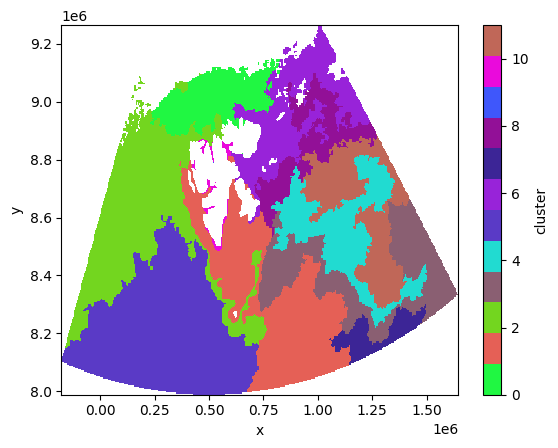

In [76]:
df_xr["cluster"].plot(cmap=random_colormap)


# N. of clusters

In [77]:
def compute_cluster_centers(X, labels):
    unique_labels = np.unique(labels)
    centers = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    return centers

def special_clustering_func(X, k, w):
    m = AgglomerativeClustering(n_clusters=k, linkage="ward", connectivity=w.sparse)
    m.fit(X)
    centers = compute_cluster_centers(X, m.labels_)
    return centers, m.labels_

def calculate_wcss(X, centers, labels):
    wcss = 0
    for i, center in enumerate(centers):
        wcss += np.sum((X[labels == i] - center) ** 2)
    return wcss

In [78]:
dfnp = df_numeric.to_numpy()


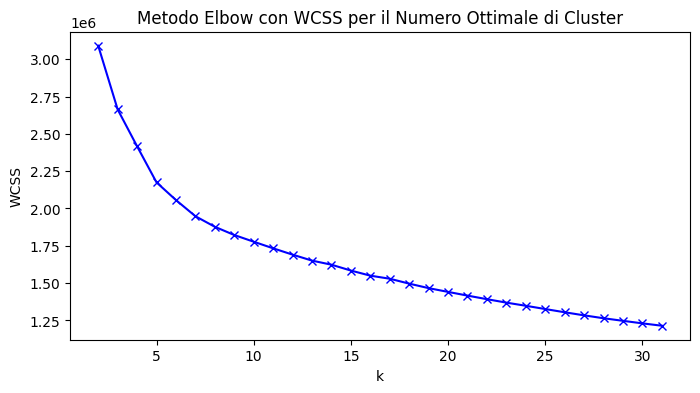

In [79]:
# Calcola la WCSS per un intervallo di valori di k
wcss_values = []
K = range(2, 32)  # Sostituisci con il tuo intervallo di k
for k in K:
    centers, labels = special_clustering_func(dfnp, k, w)
    wcss = calculate_wcss(dfnp, centers, labels)
    wcss_values.append(wcss)

# Crea il grafico Elbow
plt.figure(figsize=(8, 4))
plt.plot(K, wcss_values, 'bx-')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Metodo Elbow con WCSS per il Numero Ottimale di Cluster')
plt.show()

In [80]:
def calculate_distances(wcss_values, K):
    # Normalizza i valori WCSS e i valori di k
    wss_norm = (wcss_values - min(wcss_values)) / (max(wcss_values) - min(wcss_values))
    k_values_norm = (K - min(K)) / (max(K) - min(K))

    # Calcola la distanza di ogni punto dalla linea tra il primo e l'ultimo punto
    n_points = len(wcss_values)
    all_coords = np.vstack((k_values_norm, wss_norm)).T
    first_point = all_coords[0]
    line_vec = all_coords[-1] - all_coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coords - first_point
    scalar_product = np.sum(vec_from_first * line_vec_norm, axis=1)
    vec_to_line = vec_from_first - np.outer(scalar_product, line_vec_norm)
    distance_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    
    # Trova il punto con la massima distanza dalla linea, che è il punto del gomito
    k_opt = np.argmax(distance_to_line) + 2 # Aggiungi 2 perché l'indice inizia da 2 in Python

    return k_opt, distance_to_line

# Assumi che wcss_values e K siano già stati definiti
# Esempio:
# wcss_values = [...]
# K = range(2, 10)

k_opt, distance_to_line = calculate_distances(wcss_values, np.array(list(K)))

# Stampa il numero ottimale di cluster
print("Il numero ottimale di cluster è:", k_opt)

Il numero ottimale di cluster è: 8


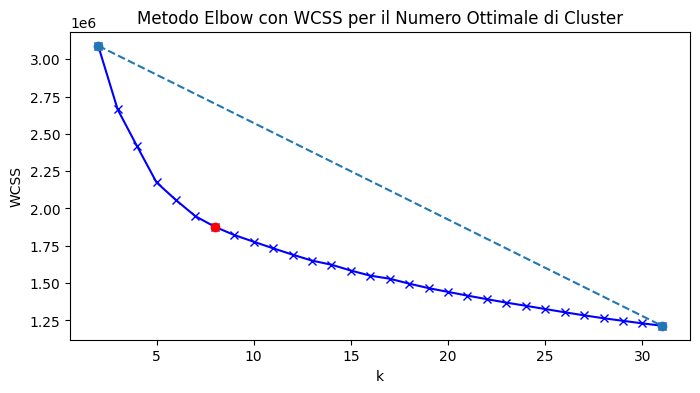

In [81]:
# Plotta il grafico
plt.figure(figsize=(8, 4))
plt.plot(K, wcss_values, 'bx-')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Metodo Elbow con WCSS per il Numero Ottimale di Cluster')
plt.plot(K[k_opt - 2], wcss_values[k_opt - 2], 'ro')  # punto del gomito
# add line connecting 1st and lat point
plt.plot([K[0], K[-1]], [wcss_values[0], wcss_values[-1]], 'o--')
plt.show()

In [95]:
# save csv con wcss_values and K
df_wcss = pd.DataFrame({'k':K, 'wcss':wcss_values})
df_wcss.to_csv('/mnt/d/Dropbox/R_projects/SVpheno/data/1.0_wcss_'+str(k_opt)+'_elbow_metrics_cl_CLEAN.csv', index=False)

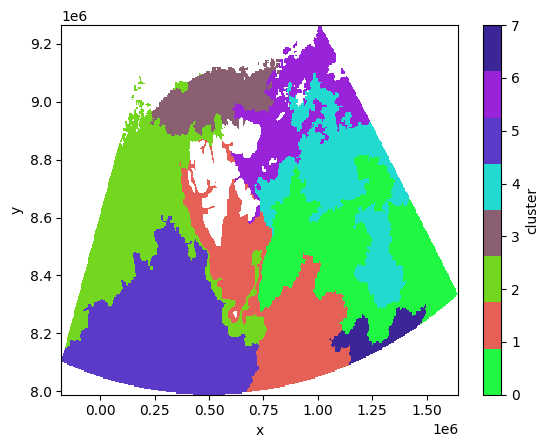

In [85]:
# Set the seed for reproducibility
np.random.seed(123456)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=k_opt
)
# Fit algorithm to the data
# Usa solo le colonne numeriche per il clustering (escludi oggetti Point o altre colonne non numeriche)


# Ora applica il modello di clustering
model.fit(df_numeric)


# attacco la colonna cluster al df_cl
df_cluster = pd.DataFrame({'x':df_cl_xy.x, 'y':df_cl_xy.y, 'cluster':model.labels_})
df_cluster.head()

df_xr = df_cluster.set_index(['y','x']).to_xarray()


num_clusters = np.unique(df_cluster.cluster).size
random_colors = np.random.rand(num_clusters, 3)
random_colormap = ListedColormap(random_colors)

df_xr["cluster"].plot(cmap=random_colormap)

df_xr.to_netcdf('/mnt/d/Dropbox/R_projects/SVpheno/data/1.0_cluster_'+ str(k_opt) + '_elbow_metrics.nc')


# GAP su spatial clustering


In [93]:
from sklearn.cluster import AgglomerativeClustering

def special_clustering_func(X, k):
    """ 
    Funzione di clustering speciale che utilizza il modello 
    AgglomerativeClustering da sklearn.
    """
    
    # Utilizza il modello AgglomerativeClustering
    m = AgglomerativeClustering(n_clusters=k,
                                linkage="ward", connectivity=w.sparse)
    m.fit(X)
    
def compute_cluster_centers(X, labels):
    unique_labels = np.unique(labels)
    centers = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    return centers


def special_clustering_func(X, k):
    m = AgglomerativeClustering(n_clusters=k, linkage="ward", connectivity=w.sparse)
    m.fit(X)
    centers = compute_cluster_centers(X, m.labels_)
    return centers, m.labels_

In [102]:
optimalk = OptimalK(clusterer=special_clustering_func, parallel_backend='joblib', n_iter = 1, n_jobs=8)
n_clusters = optimalk(dfnp, cluster_array=np.arange(2, 36))


print(f'Il numero ottimale di cluster è: {n_clusters}')

Il numero ottimale di cluster è: 35


In [103]:
# save csv con gap_df
df_gap = optimalk.gap_df
df_gap.to_csv('/mnt/d/Dropbox/R_projects/SVpheno/data/1.0_gap_'+str(n_clusters)+'_gap_metrics_cl_CLEAN.csv', index=False)

df_gap


,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,2.0,5.104798,205098.031448,0.000465,5.062496e+08,5.845667e+08,-0.147839,5.846105e+08
1,3.0,5.253127,215585.810127,0.000489,5.065327e+08,5.848937e+08,-0.096568,5.849140e+08
2,4.0,5.350207,225850.945125,0.000512,5.066639e+08,5.850451e+08,-0.104795,5.850692e+08
3,5.0,5.455533,234010.429892,0.000531,5.068196e+08,5.852249e+08,-0.055309,5.852309e+08
4,6.0,5.511381,237529.225843,0.000539,5.068580e+08,5.852693e+08,-0.053395,5.852759e+08
5,7.0,5.565309,235237.131850,0.000534,5.069010e+08,5.853190e+08,-0.036386,5.853207e+08
6,8.0,5.602221,231816.846903,0.000526,5.069126e+08,5.853323e+08,-0.029196,5.853318e+08
7,9.0,5.631939,229933.830328,0.000522,5.069094e+08,5.853287e+08,-0.024332,5.853268e+08
8,10.0,5.656790,228483.925431,0.000519,5.068973e+08,5.853146e+08,-0.024512,5.853128e+08
9,11.0,5.681819,227695.436081,0.000517,5.068852e+08,5.853007e+08,-0.024186,5.852993e+08


In [114]:
# qual è il massimo di diff in gap?
max(df_gap['diff*'])

#a che riga corrisponde?
df_gap[df_gap['diff*'] == max(df_gap['diff*'])]

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
6,8.0,5.602221,231816.846903,0.000526,5.069126e+08,5.853323e+08,-0.029196,5.853318e+08


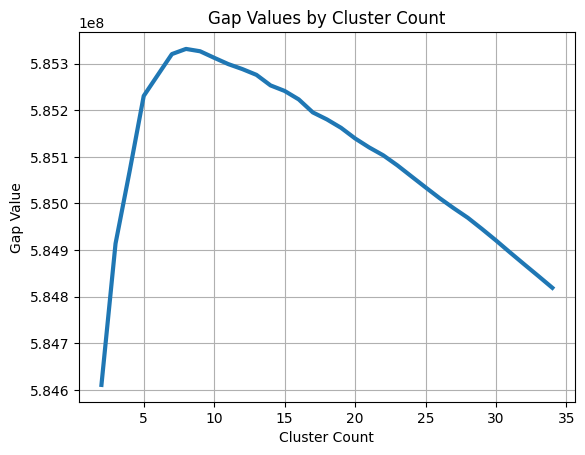

In [118]:
plt.plot(optimalk.gap_df.n_clusters, optimalk.gap_df["diff*"], linewidth=3)
#plt.scatter(optimalk.gap_df[optimalk.gap_df.n_clusters == n_clusters].n_clusters,
#            optimalk.gap_df[optimalk.gap_df.n_clusters == n_clusters].diff, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [119]:
n_clusters = 8

In [120]:
# Set the seed for reproducibility
np.random.seed(123456)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=n_clusters
)
# Fit algorithm to the data

df_numeric.columns = df_numeric.columns.astype(str)

model.fit(df_numeric)

AgglomerativeClustering(connectivity=<89329x89329 sparse matrix of type '<class 'numpy.float64'>'
	with 711060 stored elements in Compressed Sparse Row format>,
                        n_clusters=8)

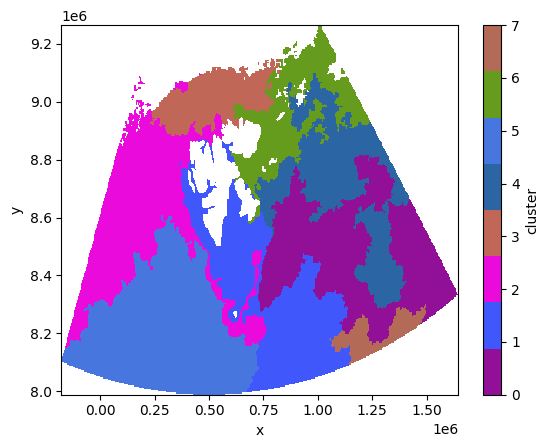

In [123]:


# attacco la colonna cluster al df_cl
df_cluster = pd.DataFrame({'x':df_cl_xy.x, 'y':df_cl_xy.y, 'cluster':model.labels_})
df_cluster.head()

df_xr = df_cluster.set_index(['y','x']).to_xarray()


num_clusters = np.unique(df_cluster.cluster).size
random_colors = np.random.rand(num_clusters, 3)
random_colormap = ListedColormap(random_colors)

num_clusters


df_xr["cluster"].plot(cmap=random_colormap)


save the results

In [125]:
# new data frame with id from df_pivotCL row names and cluster labels


df_xr.to_netcdf('/mnt/d/Dropbox/R_projects/SVpheno/data/1.0_cluster_'+ str(n_clusters) + '_gap_nrefs_default.nc')


## n_refs = 500


In [ ]:
optimalk = OptimalK(clusterer=special_clustering_func, parallel_backend='joblib', n_iter = 1, n_jobs=8, n_refs = 500)
n_clusters = optimalk(dfnp, cluster_array=np.arange(2, 36))

# save csv con gap_df
df_gap = optimalk.gap_df
df_gap.to_csv('/mnt/d/Dropbox/R_projects/SVpheno/data/1.0_gap_'+str(n_clusters)+'_gap_metrics_cl_n_refs500.csv', index=False)

df_gap
